In [33]:
import math
import random
import copy
import tikzplotlib

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.spatial.distance import cdist

import main

1. Generate distribution with Mitchell algorithm

In [34]:
r = 1           # circle radius
grid = [100, 100]
width, height = grid

m = 2           # number of starting points
N = 128         # number of all points

In [35]:
## Selects two random points on a grid
initial = np.array([ [random.uniform(0,1)*width, random.uniform(0,1)*height] for i in range(m) ])

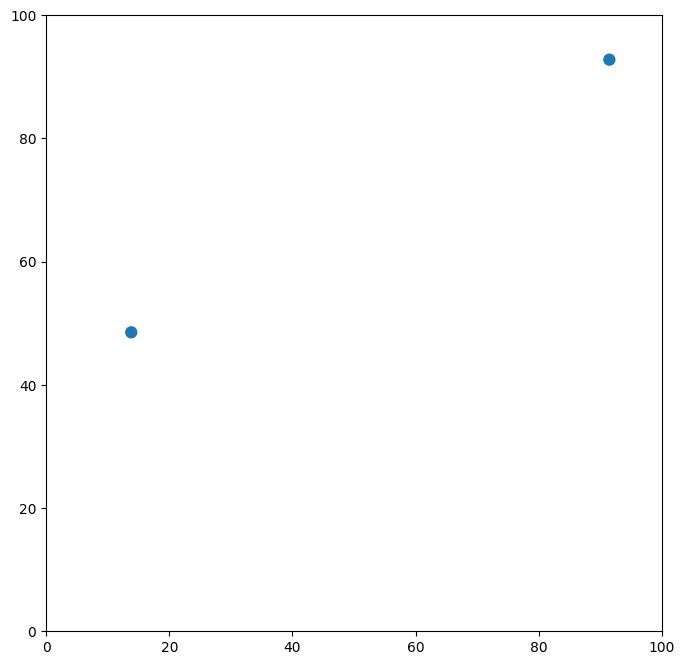

In [36]:
plt.figure(figsize=(8,8))

for center in initial:
    circle = plt.Circle(center, radius=r)
    plt.gca().add_patch(circle)

plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)
plt.show()

In [37]:
## now generate distribution with Mitchell algorithm
dist = main.distribution(initial, grid, N)
#display(dist.samples)

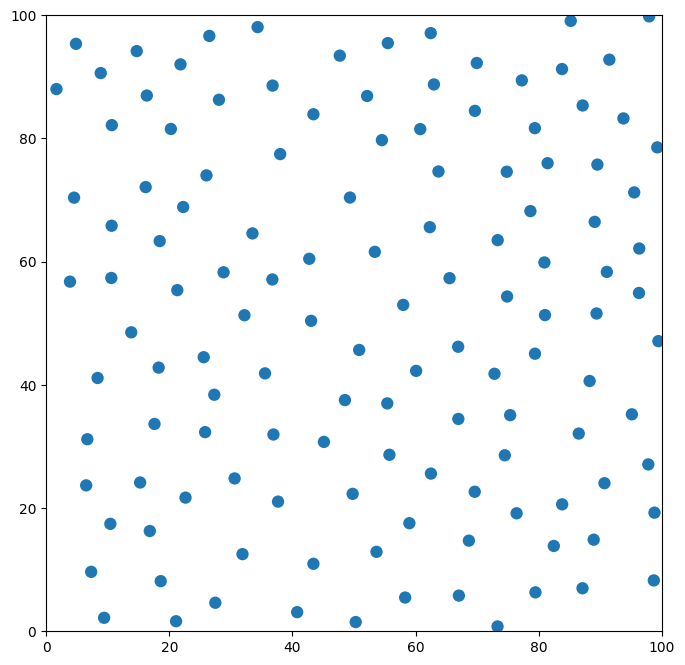

In [38]:
plt.figure(figsize=(8,8))

for center in dist.samples:
    circle = plt.Circle(center, radius=r)
    plt.gca().add_patch(circle)

    print(center[0], center[1], sep='\t', file=open('../gnuplot/porazdelitev_1024.txt', 'a'))

plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)
plt.show()

____
2. Turn points into ellipses with random orientations

In [39]:
a, eps = 5, math.sqrt(21)/5         # big semi-axis and eccentricity
b = a*math.sqrt(1-eps**2)           # small semi-axis
a_width, b_height = 2*a, 2*b        # small and big semi-axis for patches

(0.0, 100.0)

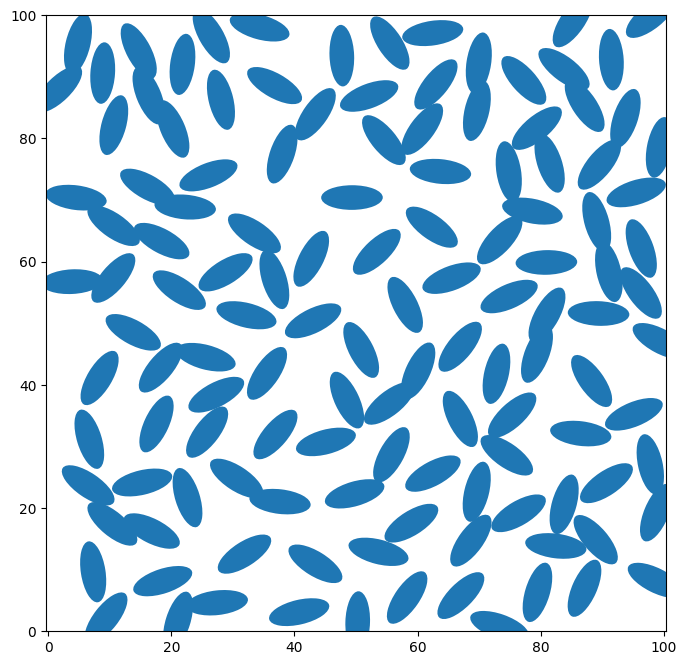

In [40]:
## generate ellipses
plt.figure(figsize=(8,8))

new_dist = main.ellipses(dist, a, b)

for center in new_dist.ell:
    ellipse = main.ellipse.convert_to_patches(center, a_width, b_height)
    plt.gca().add_patch(ellipse)

# plt.gca().set_aspect('equal')
plt.axis('equal')

plt.xlim(0.0, width)
plt.ylim(0.0, height)
# plt.savefig("elipse_512.png")
# plt.show()

# tikzplotlib.save("test.tex")

_____
3. Wertheim-Perram contact function

In [41]:
## distance matrix between all the centres
S = [x.center for x in new_dist.ell]
distance = cdist(S, S, dist.periodic_metric)

## matrix of neighbouring ellipses, which are less than 2*a apart
in_proximity = [np.where((line<=2*a) & (line!=0)) for line in distance]

(0.0, 100.0)

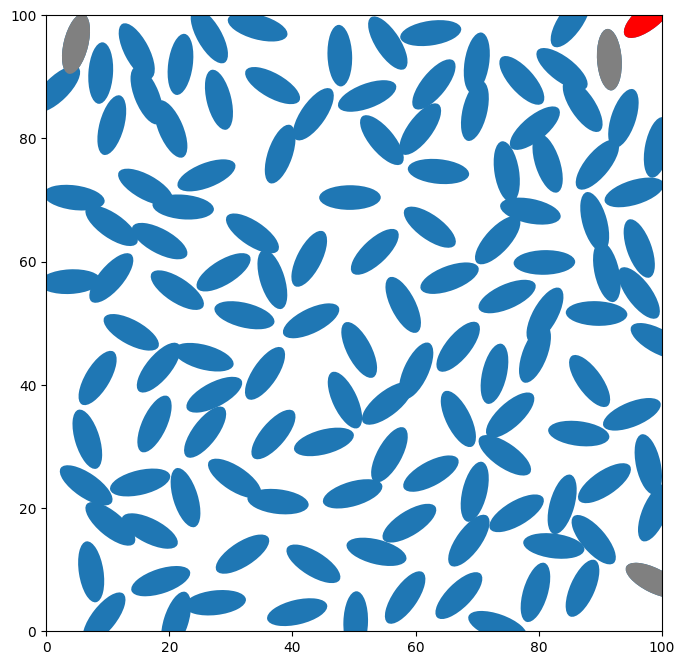

In [42]:
plt.figure(figsize=(8,8))

for center in new_dist.ell:
    ellipse = main.ellipse.convert_to_patches(center, a_width, b_height)
    plt.gca().add_patch(ellipse)

## select ellipse 'i' and check its proximity
i = random.randint(0,N-1)

i_ellipse = new_dist.ell[i]

ell_patch = main.ellipse.convert_to_patches(i_ellipse, a_width, b_height)
plt.gca().add_patch(ell_patch)
ell_patch.set_facecolor('r')

i_neighbourhood = new_dist.ell[in_proximity[i]]
for E in i_neighbourhood:
    ell_patch = main.ellipse.convert_to_patches(E, a_width, b_height)
    plt.gca().add_patch(ell_patch)
    ell_patch.set_facecolor('grey')

plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)

# tikzplotlib.save("test.tex")


(0.0, 100.0)

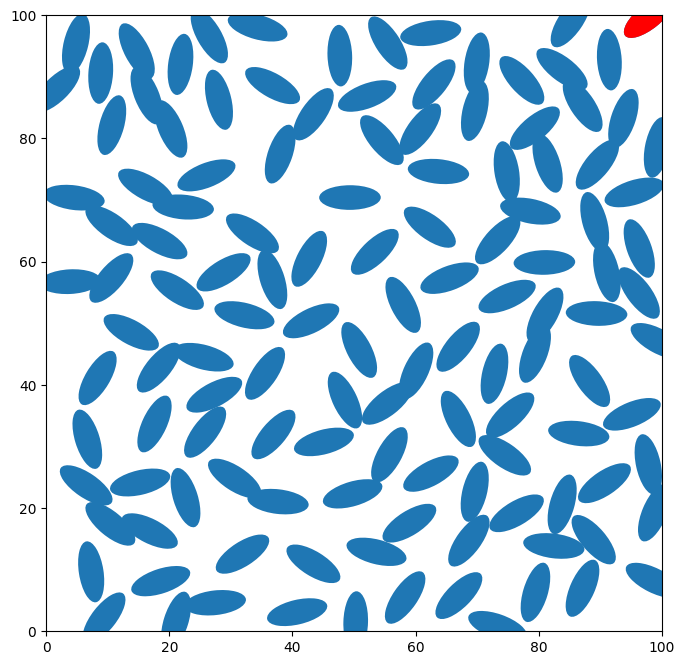

In [43]:
plt.figure(figsize=(8,8))

for center in new_dist.ell:
    ellipse = main.ellipse.convert_to_patches(center, a_width, b_height)
    plt.gca().add_patch(ellipse)

## display only those ellipses that are touching or overlapping i-th ellipse
close = np.array([new_dist.mu(i_ellipse, neighbour) for neighbour in i_neighbourhood])

ell_patch = main.ellipse.convert_to_patches(i_ellipse, a_width, b_height)
plt.gca().add_patch(ell_patch)
ell_patch.set_facecolor('r')

## the ones that have mu < 1 are overlapping
in_contact = i_neighbourhood[np.where(close<1)]
for E in in_contact:
    ell_patch = main.ellipse.convert_to_patches(E, a_width, b_height)
    plt.gca().add_patch(ell_patch)
    ell_patch.set_facecolor('grey')

plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)
# tikzplotlib.save("test.tex")


___

In [44]:
def energy(elipsa_a, okolica_a):
    new_E, new_Z = 0, 0
    if len(okolica_a) != 0:
        all_mu = np.array([new_dist.mu(elipsa_a, elipsa_b) for elipsa_b in okolica_a])

        E = -np.log(all_mu[np.where(all_mu<=1)])
        new_Z = len(E)
        new_E = np.sum(E)
    return np.asarray([new_E, new_Z])

In [45]:
print(new_dist.energy(new_dist.ell[i], new_dist.ell[in_proximity[i]]))

[0. 0.]


In [46]:
temp = np.asarray([new_dist.energy(new_dist.ell[i], new_dist.ell[in_proximity[i]]) for i in range(N)])

In [47]:
Energy = temp[:,0]
coord_number = temp[:,1]

---

In [48]:
a, eps = 6, math.sqrt(21)/5
# a, b = 6, 1
b = a*math.sqrt(1-eps**2)

new_dist.a = a
new_dist.b = b
new_dist.fix_A

In [49]:
## distance matrix between all the centres
S = [x.center for x in new_dist.ell]
distance_matrix = cdist(S, S, dist.periodic_metric)

## matrix of indices of neighbouring ellipses, which are less than 2*a apart
in_proximity = [np.where((line<=2*new_dist.a) & (line!=0)) for line in distance_matrix]

In [50]:
Energy, coord_number, accepted, rejected = new_dist.metropolis(in_proximity, n=1000)

In [51]:
from matplotlib import patches, colors, cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

## let's have fun with colours --> map energy values to color palette
my_palette = LinearSegmentedColormap.from_list('custom red', ["#577590", "#f94144", "#f8961e"], N=256)
# my_palette = LinearSegmentedColormap.from_list('custom red', ["#ffffff", "#ff0a54"], N=256)

## heatmap of energy
# minima = np.round(np.min(Energy), 2)
# maxima = np.round(np.max(Energy), 2)

## heatmap of coordination number
minima = np.round(np.min(coord_number), 2)
maxima = np.round(np.max(coord_number), 2)

norm = colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=my_palette)

(0.0, 100.0)

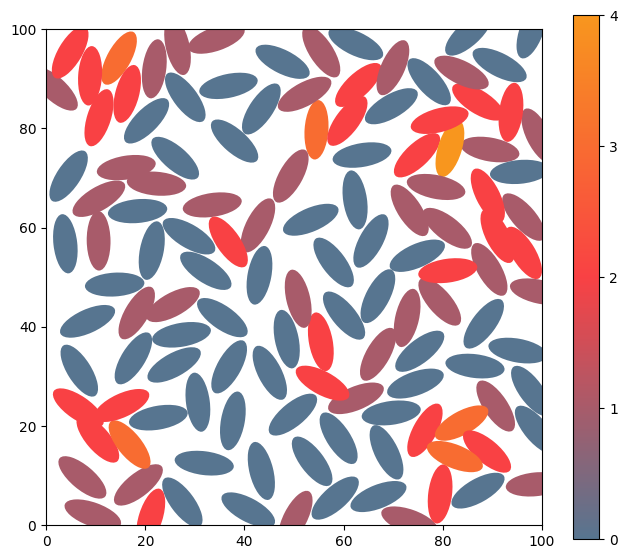

In [52]:
plt.figure(figsize=(8,8))

## dimensions for patches
a_width, b_height = 2*new_dist.a, 2*new_dist.b

for center in new_dist.ell:
    index = np.where(new_dist.ell == center)
    # v = Energy[-1,index]
    v = coord_number[-1,index]

    ellipse = main.ellipse.convert_to_patches(center, a_width, b_height)
    plt.gca().add_patch(ellipse)
    ellipse.set_facecolor(mapper.to_rgba(v)[0])
    ellipse.set_label('_nolegend_')

cbar = np.round( np.linspace(minima, maxima, 5, endpoint=True), 2)
plt.colorbar(mapper, ticks=cbar, shrink=0.85, orientation='vertical')

plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)

# tikzplotlib.save("test.tex")

___

In [53]:
mu, kappa = 0.0, 3        # mean and dispersion
s = np.random.vonmises(mu, kappa, 1000)

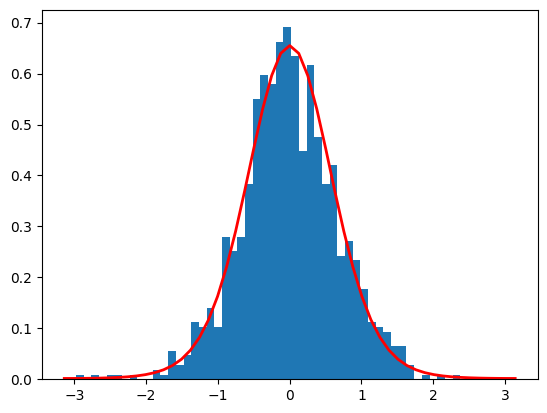

In [54]:
from scipy.special import i0
plt.hist(s, 50, density=True)
x = np.linspace(-math.pi, math.pi, num=51)
y = np.exp(kappa*np.cos(x-mu))/(2*np.pi*i0(kappa))
plt.plot(x, y, linewidth=2, color='r')
plt.show()

___
Orientational correlation function

$$g_l(r, t) = <\psi_{i,l} \cdot \psi^*_{j,l}> \qquad 
\psi_{i,l} = \frac{1}{Z_j} \sum_{k=1}^{Z_j} \exp(\mathrm{i}\,l\,\theta_{jk})$$
where $\theta_{jk}$ is the angle between each neighbour $k$ of $j$-th ellipse.

In [55]:
r = np.linspace(0.6, 3, 100)
y = new_dist.angle_correlation(r*new_dist.a)

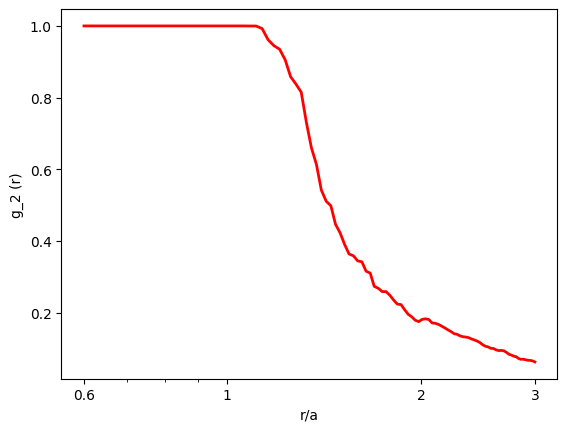

In [56]:
plt.plot(r, y, linewidth=2, color='r')

plt.xscale('log')
plt.xticks([0.6, 1, 2, 3], [0.6, 1, 2, 3])

plt.xlabel('r/a')
plt.ylabel('g_2 (r)')
plt.show()

___
5. growth and rotation

In [14]:
## start with small ellipses
a, eps = 4, 2/3                 # big semi-axis and eccentricity
b = a*math.sqrt(1-eps**2)       # small semi-axis
a_width, b_height = 2*a, 2*b    # small and big semi-axis for patches

## distance matrix between all the centres
S = [x.center for x in new_dist.ell]
distance = cdist(S, S, dist.periodic_metric)

## matrix of neighbouring ellipses, which are less than 2*a apart
in_proximity = [np.where((line<=2*a) & (line!=0)) for line in distance]

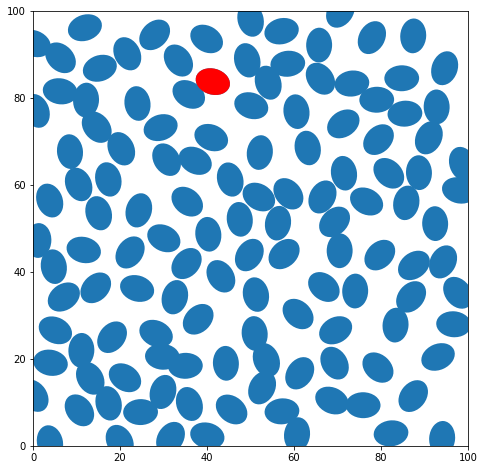

In [15]:
## generate ellipses
plt.figure(figsize=(8,8))

## select random ellipse
j = random.randint( 0, N-1 )

for center in new_dist.ell:
    ellipse = main.ellipse.convert_to_patches(center, a_width, b_height)
    plt.gca().add_patch(ellipse)

j_ellipse = new_dist.ell[j]

ell_patch = main.ellipse.convert_to_patches(j_ellipse, a_width, b_height)
plt.gca().add_patch(ell_patch)
ell_patch.set_facecolor('r')

plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)
# plt.savefig("elipse_512.png")
plt.show()

In [16]:
## rotate random ellipse by random angle
theta = np.random.vonmises(new_dist.ell[j].angle, kappa)
new_dist.ell[j].angle = theta

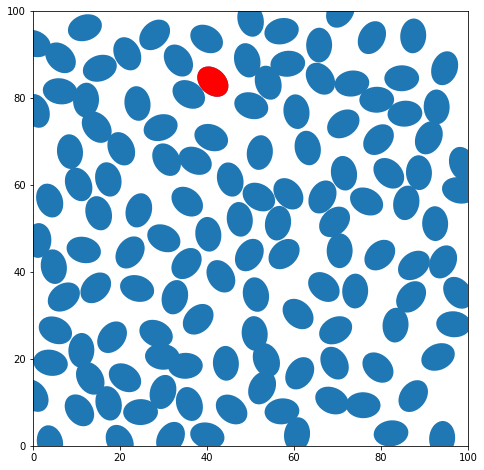

In [17]:
## generate ellipses
plt.figure(figsize=(8,8))

for center in new_dist.ell:
    ellipse = main.ellipse.convert_to_patches(center, a_width, b_height)
    plt.gca().add_patch(ellipse)

j_ellipse = new_dist.ell[j]

ell_patch = main.ellipse.convert_to_patches(j_ellipse, a_width, b_height)
plt.gca().add_patch(ell_patch)
ell_patch.set_facecolor('r')


plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)
# plt.savefig("elipse_512.png")
plt.show()